# Topological optimization of the  ICLR acronym

In this notebook, we show how a topological loss can be use to increase the 'connectedness' of a data set.

We start by setting the working directory and importing the necessary libraries.

In [1]:
# Set working directory
import os
os.chdir("..")

# Handling arrays and data.frames
import numpy as np

# Functions for deep learning (Pytorch)
import torch
from torch import nn

# Pytorch compatible topology layer
from topologylayer.nn import AlphaLayer
from topembed import DiagramFeature

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Load and view data

We load and view the data as follows.

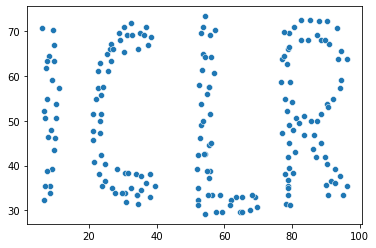

In [2]:
# Load the data
data = np.loadtxt(os.path.join("Data", "ICLR.csv"), delimiter=" ", skiprows=1, usecols=(1, 2))

# Plot the data
fig, ax = plt.subplots()
sns.scatterplot(x=data[:,0], y=data[:,1])
plt.show()

## Apply topological optimization to the embedding

We now show how we can use topological optimization to encourage the model underlying the data to become connected. As a topological loss, we will use the total (finite) 0-dimensional persistence.

In [3]:
# Define topological optimization

def g(p): # function that returns the persistence d of a point (0, d) with d < inf
    return p[1] if p[1] < np.inf else torch.tensor(0).type(torch.float)
top_layer = AlphaLayer(maxdim=1) # alpha complex layer
total_persistence = DiagramFeature(dim=0, g=g) # compute total 0-dimensional persistence

def top_criterion(output):
    
    dgminfo = top_layer(output)            
    loss = total_persistence(dgminfo)
    
    return loss

We can now conduct the topological optimization as follows.

In [4]:
# Dictionary to store optimized point cloud for multiple epochs
optimized = dict()

# Learning hyperparameters
num_epochs = [5, 50, 100, 250, 500, 1000]
learning_rate = 1e0

# Conduct topologically regularized embedding
Y = torch.autograd.Variable(torch.tensor(data).type(torch.float), requires_grad=True)
optimizer = torch.optim.Adam([Y], lr=learning_rate)

for epoch in range(num_epochs[len(num_epochs) - 1]):
    optimizer.zero_grad()
    loss = top_criterion(Y)
    loss.backward()
    optimizer.step()

    if epoch == 0 or (epoch + 1) % (int(num_epochs[len(num_epochs) - 1]) / 10) == 0:
        print ("[epoch %d] [topological loss: %f]" % (epoch + 1, loss.item()))
        
    if epoch + 1 in num_epochs:
        optimized[epoch + 1] = Y.detach().numpy().copy()

[epoch 1] [topological loss: 457.542542]
[epoch 100] [topological loss: 128.645401]
[epoch 200] [topological loss: 92.025467]
[epoch 300] [topological loss: 85.552605]
[epoch 400] [topological loss: 80.295883]
[epoch 500] [topological loss: 75.494385]
[epoch 600] [topological loss: 74.632774]
[epoch 700] [topological loss: 68.643341]
[epoch 800] [topological loss: 72.190308]
[epoch 900] [topological loss: 66.964455]
[epoch 1000] [topological loss: 65.702080]


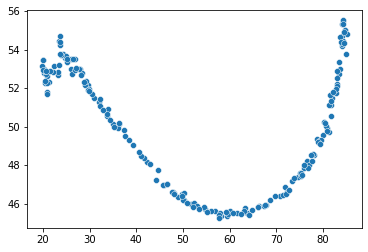

In [5]:
# View topologically optimized data for a particular number of epochs
epoch = 250
fig, ax = plt.subplots()
sns.scatterplot(x=optimized[epoch][:,0], y=optimized[epoch][:,1])
plt.show()

Finally, we save the optimized data sets for plotting in R.

In [6]:
for epoch in num_epochs:
    np.savetxt(os.path.join("Data", "ICLR Optimized" , "epochs" + str(epoch) + ".csv"), 
               optimized[epoch], delimiter=",")